
⎯⎯⎯⎯ Sector 1 ⎯⎯⎯⎯
Sector: 18


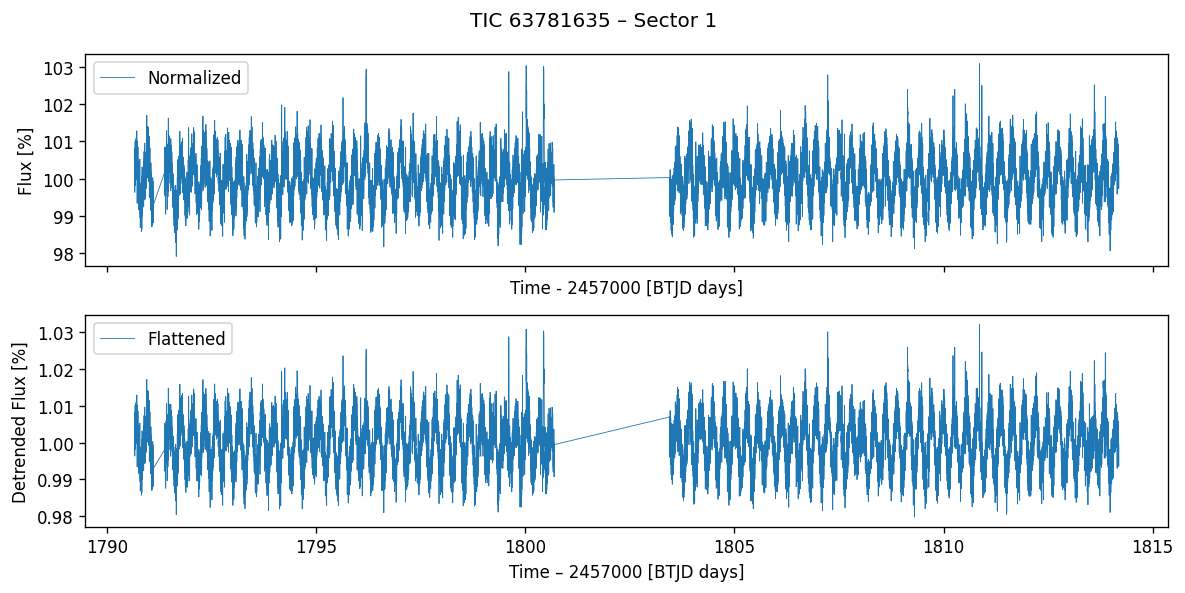

Best LS period: 0.2757 d ± 0.0016 days


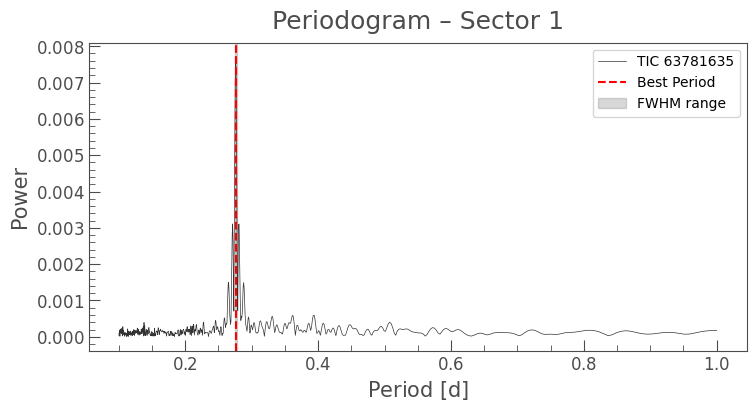


⎯⎯⎯⎯ Sector 2 ⎯⎯⎯⎯
Sector: 58


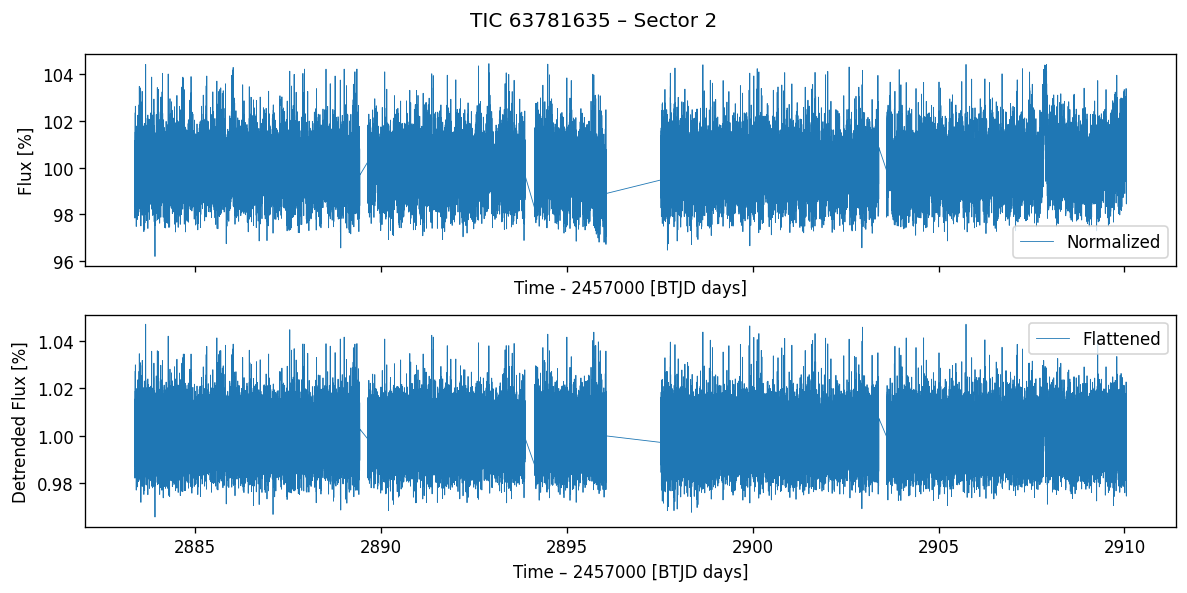

Best LS period: 0.1380 d ± 0.4500 days


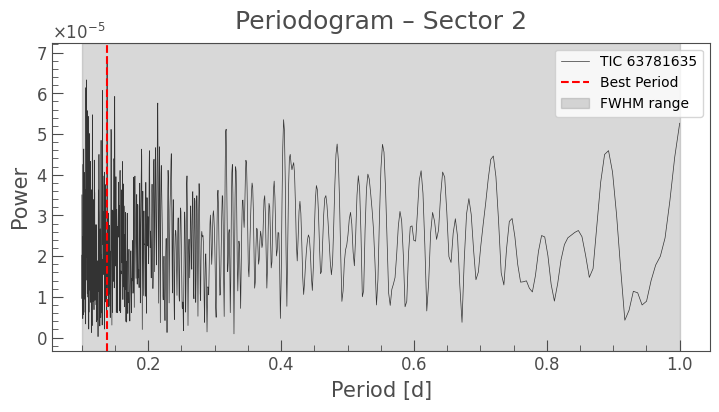


⎯⎯⎯⎯ Sector 3 ⎯⎯⎯⎯
Sector: 58


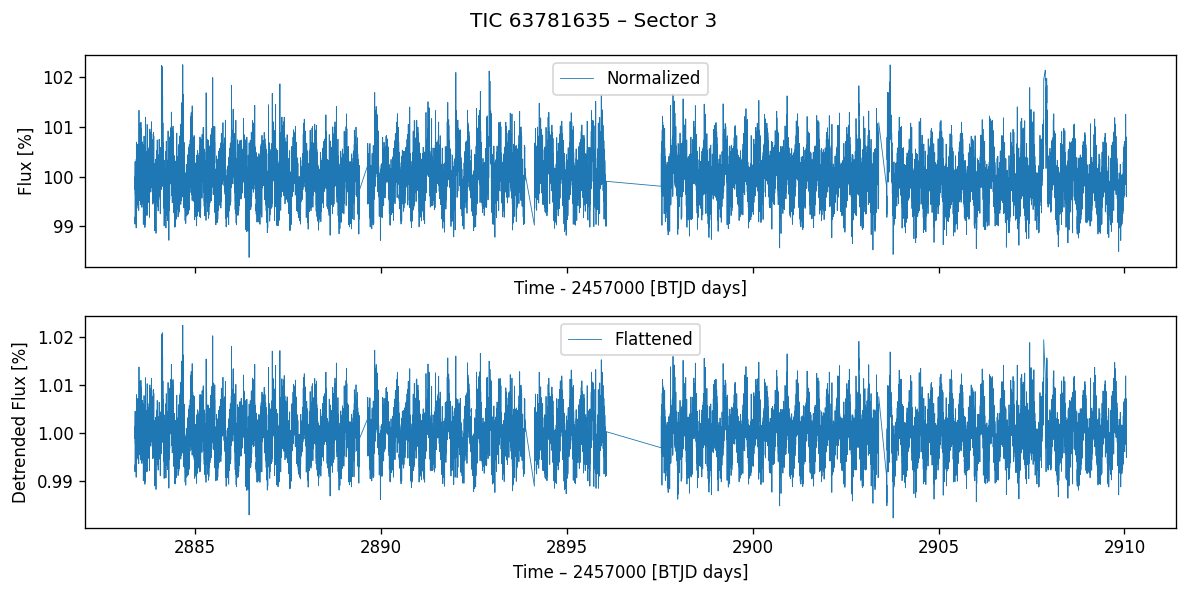

Best LS period: 0.2759 d ± 0.0014 days


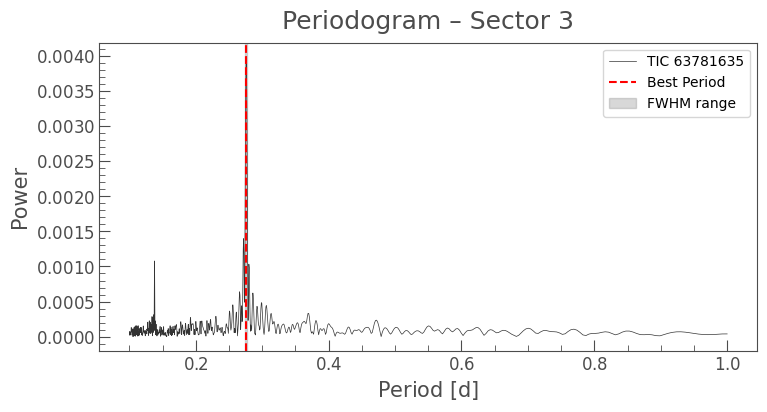


⎯⎯⎯⎯ Sector 4 ⎯⎯⎯⎯
Sector: 85


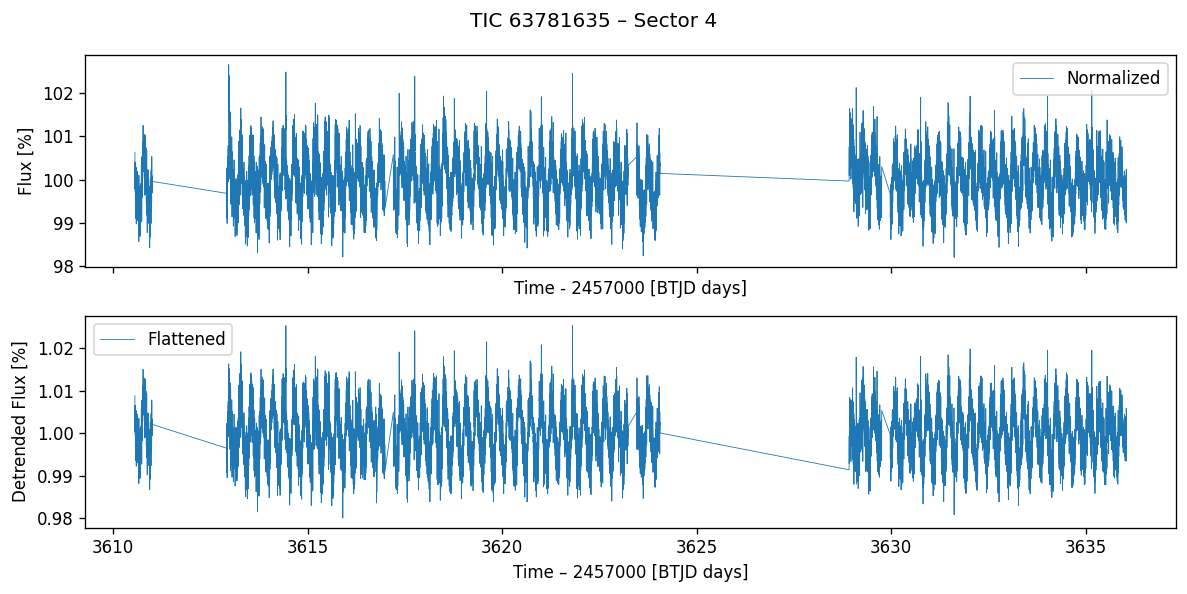

Best LS period: 0.2762 d ± 0.0015 days


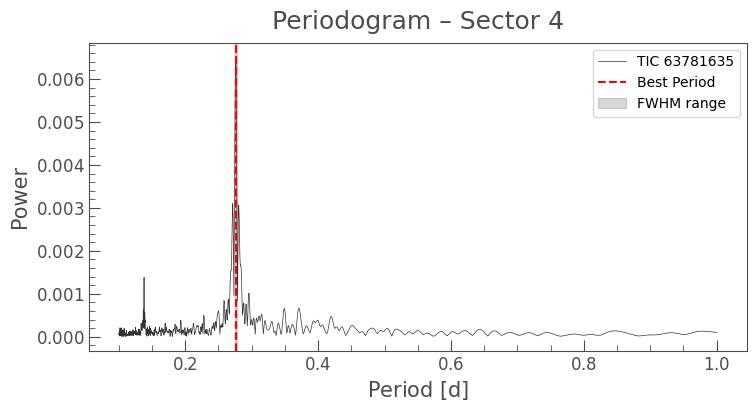


Summary Table of Periods:
   Sector           LS_period_d  LS_err_d
0      18  0.2757311309828554 d  0.001620
1      58  0.1380101951946459 d  0.449988
2      58  0.2758804317067702 d  0.001430
3      85  0.2761847530715947 d  0.001493

Saved table -> TIC63781635_periods_table.csv


In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import pandas as pd

# Target TIC ID
tic_id = "63781635"

# Search for all SPOC light curves from TESS
sr = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC")

# Download light curves (PDCSAP_FLUX only)
lcs = sr.download_all(flux_column="pdcsap_flux", quality_bitmask="default")

results = []

# Loop over each sector
for i, lc_sector in enumerate(lcs):
    print(f"\n⎯⎯⎯⎯ Sector {i+1} ⎯⎯⎯⎯")
    print(f"Sector: {lc_sector.sector}")

    # Clean and normalize light curve
    lc_clean = lc_sector.normalize(unit="percent").remove_nans().remove_outliers(sigma=5)
    
    # Flatten for long-term trends
    lc_flat = lc_clean.flatten(window_length=401)

    # Plot raw and flattened lightcurve
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, dpi=120)
    lc_clean.plot(ax=ax[0], label="Normalized")
    ax[0].set_ylabel("Flux [%]")
    ax[0].legend()
    
    lc_flat.plot(ax=ax[1], label="Flattened")
    ax[1].set_ylabel("Detrended Flux [%]")
    ax[1].set_xlabel("Time – 2457000 [BTJD days]")
    ax[1].legend()
    plt.suptitle(f"TIC {tic_id} – Sector {i+1}")
    plt.tight_layout()
    plt.show()

    # Lomb-Scargle periodogram
    periodogram = lc_flat.to_periodogram(method="lombscargle",
                                         minimum_period=0.1,
                                         maximum_period=1)
    
    best_period = periodogram.period_at_max_power
    best_power = periodogram.max_power

    # Estimate error using FWHM of the peak
    periods = periodogram.period.value
    powers = periodogram.power.value

    half_max = best_power / 2
    above_half = np.where(powers >= half_max)[0]
    
    if len(above_half) > 1:
        fwhm_range = periods[above_half]
        period_error = np.abs(fwhm_range[-1] - fwhm_range[0]) / 2
    else:
        period_error = np.nan  # can't estimate if peak is too sharp

    print(f"Best LS period: {best_period:.4f} ± {period_error:.4f} days")

    # Plot the periodogram
    periodogram.plot(title=f"Periodogram – Sector {i+1}")
    plt.axvline(best_period.value, color='r', linestyle='--', label="Best Period")
    if len(above_half) > 1:
        plt.axvspan(fwhm_range[0], fwhm_range[-1], color='gray', alpha=0.3, label='FWHM range')
    plt.legend()
    plt.show()

#Store result
    results.append({
        "Sector": lc_sector.sector,
        "LS_period_d": best_period,
        "LS_err_d": period_error
    })

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Sector", "LS_period_d", "LS_err_d"])
print("\nSummary Table of Periods:")
print(df)

# Save to CSV
csvfile = f"TIC{tic_id}_periods_table.csv"
df.to_csv(csvfile, index=False)
print(f"\nSaved table -> {csvfile}")



<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

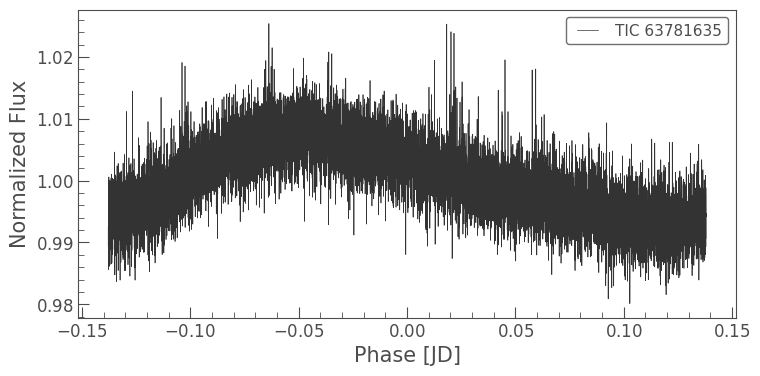

In [2]:
lc_fold_ls = lc_flat.fold(period=0.27588)
lc_fold_ls.plot()


Text(0.5, 1.0, 'Phase-Folded Light Curve (Raw vs. Binned)')

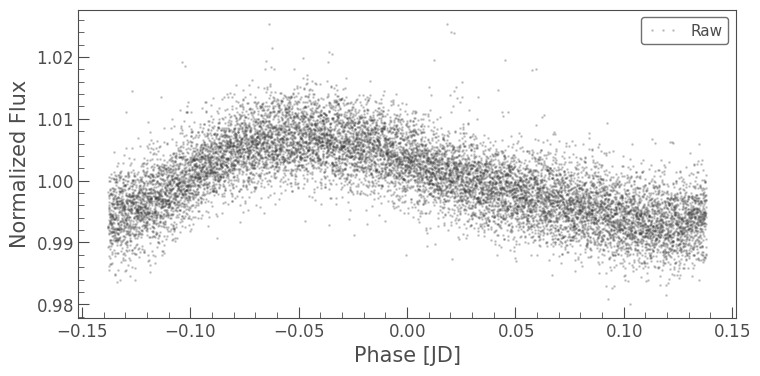

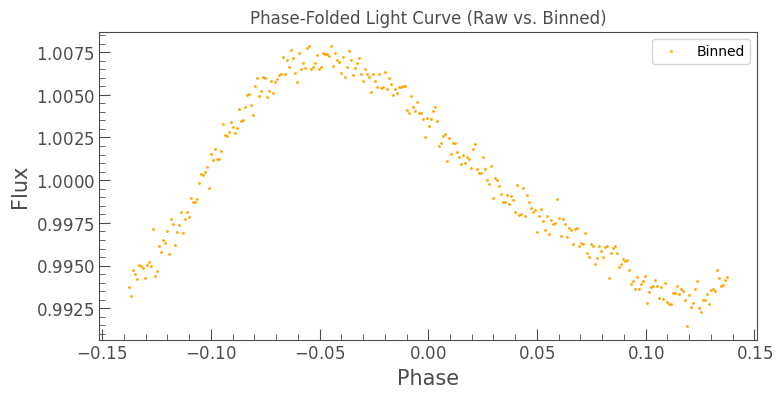

In [3]:
lc_fold_bin = lc_fold_ls.bin(bins=300)

lc_fold_ls.plot(alpha=0.2, label="Raw", marker='.', linestyle='none')  # raw data
lc_fold_bin.scatter(label="Binned", color="orange")  # binned data

plt.legend()
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.title("Phase-Folded Light Curve (Raw vs. Binned)")


In [4]:
import lightkurve as lk

# Example: search by TIC ID
search_result = lk.search_lightcurve("TIC 63781635", mission="TESS")
print(search_result)


SearchResult containing 9 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 18 2019      SPOC     120    63781635      0.0
  1 TESS Sector 58 2022      SPOC      20    63781635      0.0
  2 TESS Sector 58 2022      SPOC     120    63781635      0.0
  3 TESS Sector 85 2024      SPOC     120    63781635      0.0
  4 TESS Sector 18 2019 TESS-SPOC    1800    63781635      0.0
  5 TESS Sector 58 2022 TESS-SPOC     200    63781635      0.0
  6 TESS Sector 18 2019       QLP    1800    63781635      0.0
  7 TESS Sector 58 2022       QLP     200    63781635      0.0
  8 TESS Sector 85 2024       QLP     200    63781635      0.0


In [6]:
import numpy as np

# Assume 'folded' is your folded light curve object
folded = lc_flat.fold(period= 0.27588)
amp = np.max(folded.flux.value) - np.min(folded.flux.value)
amp_percent = amp * 100
print(f"Peak-to-peak amplitude: {amp_percent:.2f}%")


Peak-to-peak amplitude: 4.53%
